In [2]:
%pip install pandas numpy nltk transformers matplotlib wordcloud scikit-learn

   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ------------- -------------------------- 3.7/11.1 MB 19.8 MB/s eta 0:00:01
   ------------------------------- -------- 8.7/11.1 MB 22.4 MB/s eta 0:00:01
   ---------------------------------------  11.0/11.1 MB 22.2 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 17.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/44.8 MB ? eta -:--:--
   --- ------------------------------------ 3.7/44.8 MB 24.2 MB/s eta 0:00:02
   --- ------------------------------------ 4.2/44.8 MB 10.1 MB/s eta 0:00:05
   ---- ----------------------------------- 5.5/44.8 MB 8.8 MB/s eta 0:00:05
   ------- -------------------------------- 8.1/44.8 MB 9.5 MB/s eta 0:00:04
   --------- ------------------------------ 11.0/44.8 MB 10.3 MB/s eta 0:00:04
   ------------ --------------------------- 13.9/44.8 MB 10.8 MB/s eta 0:00:03
   --------------- ------------------------ 17.0/44.8 MB 11.3 MB/s eta 0:00:03

In [4]:
# Librerías de manipulación de datos
import pandas as pd
import numpy as np

# Librerías para preprocesamiento de texto
import re
import unicodedata
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

# Librerías para análisis de sentimientos con BERT
from transformers import pipeline

# Librerías para visualización
import matplotlib.pyplot as plt
from wordcloud import WordCloud


c:\Users\jkbu\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Importacion de la data

In [ ]:
# # Cargar la tabla completa
# combined_reviews = pd.read_sql("SELECT * FROM combined_reviews", con=engine)

# # Filtrar en Python
# filtered_reviews = combined_reviews.groupby('Modelo estandar').filter(lambda x: x['comentario'].nunique() >= 200)

# # Guardar la tabla filtrada nuevamente en MySQL
# filtered_reviews.to_sql('filtered_reviews', con=engine, if_exists='replace', index=False)

In [7]:
# Cargar los datos
df = pd.read_csv(r"d:\Proyecto Web Scrapping\SQL Queries\filtered_reviews.csv")

# Explorar el dataset
print(df.head())  # Ver las primeras filas
print(df.info())  # Resumen del DataFrame
print(df['calificacion'].value_counts())  # Distribución de calificaciones

                                          comentario  calificacion codigo  \
0  Si corresponde a la foto tiene un excelente re...             5    FX1   
1  El tamaño es el apropiado y para cargar fácilm...             5    FX1   
2  Muy buen producto a un excelente precio, llego...             5    FX1   
3            Me gusto mucho, y fue rápido la llegada             5    FX1   
4         Cumple lo que promete, es un lindo celular             5    FX1   

                                              Enlace  Sitio Web   Marca  \
0  https://www.falabella.com.co/falabella-co/prod...  falabella  Xiaomi   
1  https://www.falabella.com.co/falabella-co/prod...  falabella  Xiaomi   
2  https://www.falabella.com.co/falabella-co/prod...  falabella  Xiaomi   
3  https://www.falabella.com.co/falabella-co/prod...  falabella  Xiaomi   
4  https://www.falabella.com.co/falabella-co/prod...  falabella  Xiaomi   

      Modelo estandar   Precio  
0  Xiaomi Poco X6 Pro  1899900  
1  Xiaomi Poco X6 Pr

Pre-procesamiento de la Data

In [19]:
import re
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Descargar recursos de NLTK
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Configurar stopwords y lematización
stop_words = set(stopwords.words('spanish'))
lemmatizer = WordNetLemmatizer()

# Stopwords personalizadas
important_negatives = {"no", "nunca", "sin", "muy", "poco", "bastante", "mas", "dos", "mucho"}
stop_words = stop_words - important_negatives

# Diccionario de correcciones específicas
correcciones = {
    "q": "que", "exelente": "excelente", "espectativas": "expectativas", "celu": "celular",
    "bno": "bueno", "auriculare": "auriculares", "cel": "celular", "sultra": "ultra",
    "aprox": "aproximadamente", "mobil": "movil", "amooo": "amo", "perfeccoon": "perfeccion",
    "camras": "camaras", "escojer": "escoger", "encamta": "encanta", "aser": "hacer",
    "calentarce": "calentarse", "parese": "parece", "nuy": "muy", "okey": "okay",
    "espetativas": "expectativas", "pq": "por que", "mut": "muy", "ecxelente": "excelente",
    "execelente": "excelente", "bna": "buena", "redimiento": "rendimiento", "qe": "que",
    "encata": "encanta", "sobrecalienta": "calienta", "buenardo": "bueno", "demaciado": "demasiado",
    "(Esta reseña se ha recibido a través de una promoción.)": ""
}

# Función para eliminar tildes sin alterar estructura
def remove_accents(text):
    accents = {'á': 'a', 'é': 'e', 'í': 'i', 'ó': 'o', 'ú': 'u',
               'Á': 'A', 'É': 'E', 'Í': 'I', 'Ó': 'O', 'Ú': 'U'}
    for accented_char, unaccented_char in accents.items():
        text = text.replace(accented_char, unaccented_char)
    return text

# Función para aplicar correcciones específicas
def aplicar_correcciones(text):
    tokens = text.split()
    corrected_tokens = [correcciones.get(token, token) for token in tokens]
    return ' '.join(corrected_tokens)

# Función para eliminar frases específicas antes de procesar
def eliminar_frase(text):
    return text.replace("(Esta reseña se ha recibido a través de una promoción.)", "")

# Función de limpieza básica con lematización
def clean_text_with_lemmatization(text):
    text = eliminar_frase(text)  
    text = remove_accents(text)
    text = aplicar_correcciones(text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Función de limpieza básica sin lematización
def clean_text_without_lemmatization(text):
    text = eliminar_frase(text) 
    text = remove_accents(text)
    text = aplicar_correcciones(text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\d+', '', text)
    return text

# Rellenar valores NaN en la columna 'comentario' con una cadena vacía
df['comentario'] = df['comentario'].fillna('')

# Crear columnas adicionales
df['comentario_limpio'] = df['comentario'].apply(clean_text_with_lemmatization)
df['comentario_limpio_sin_lematizar'] = df['comentario'].apply(clean_text_without_lemmatization)

# Verificar cambios
print("Primeros comentarios limpios en el DataFrame:")
print(df[['comentario', 'comentario_limpio', 'comentario_limpio_sin_lematizar']].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jkbu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jkbu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jkbu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Primeros comentarios limpios en el DataFrame:
                                          comentario  \
0  Si corresponde a la foto tiene un excelente re...   
1  El tamaño es el apropiado y para cargar fácilm...   
2  Muy buen producto a un excelente precio, llego...   
3            Me gusto mucho, y fue rápido la llegada   
4         Cumple lo que promete, es un lindo celular   

                                   comentario_limpio  \
0  si corresponde foto excelente rendimiento capa...   
1  tamaño apropiado cargar facilmente calidad ima...   
2  muy buen producto excelente precio llego rapid...   
3                         gusto mucho rapido llegada   
4                       cumple promete lindo celular   

                     comentario_limpio_sin_lematizar  
0  Si corresponde a la foto tiene un excelente re...  
1  El tamaño es el apropiado y para cargar facilm...  
2  Muy buen producto a un excelente precio llego ...  
3             Me gusto mucho y fue rapido la llegada  
4    

Análisis descriptivo

Análisis por marca:
         Total_Comentarios  Calificacion_Promedio         1         2  \
Marca                                                                   
Apple                 2644               4.892965  0.907716  0.113464   
Samsung               5004               4.831135  1.099121  0.799361   
Xiaomi                1972               4.787525  1.014199  0.354970   

                3          4          5  
Marca                                    
Apple    1.210287   4.311649  93.456884  
Samsung  1.818545   6.454836  89.828137  
Xiaomi   1.470588  13.184584  83.975659  


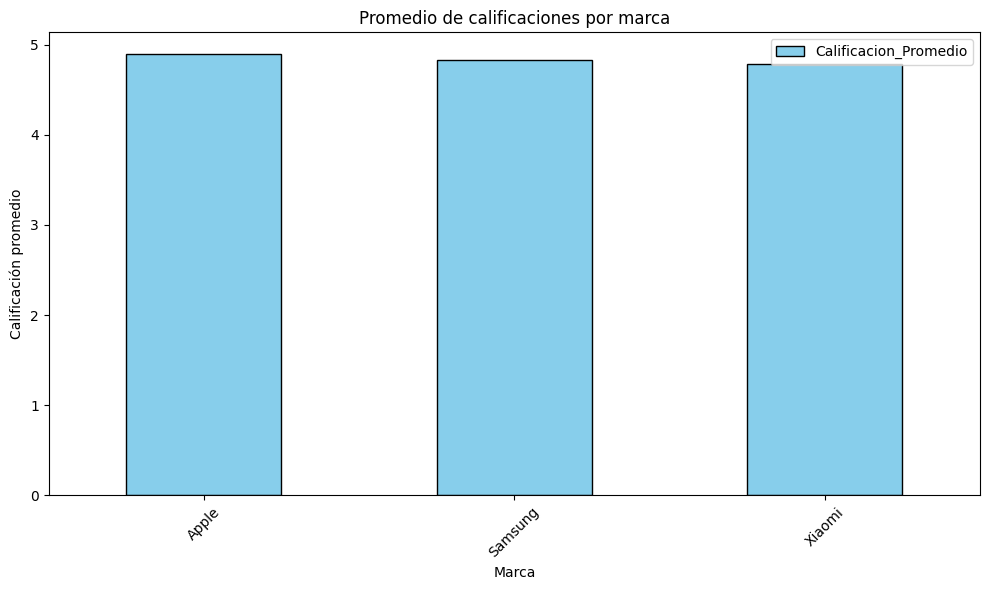

In [10]:
# Calcular la distribución por marca
distribucion_marca = df.groupby('Marca').agg(
    Total_Comentarios=('calificacion', 'count'),
    Calificacion_Promedio=('calificacion', 'mean')
)

# Proporción de calificaciones por marca
proporcion_calificaciones = df.groupby(['Marca', 'calificacion']).size().unstack(fill_value=0)
proporcion_calificaciones = proporcion_calificaciones.div(proporcion_calificaciones.sum(axis=1), axis=0) * 100

# Unir ambas tablas
analisis_marca = distribucion_marca.join(proporcion_calificaciones)

# Mostrar resultados
print("Análisis por marca:")
print(analisis_marca)

# Visualización
analisis_marca[['Calificacion_Promedio']].plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black')
plt.title("Promedio de calificaciones por marca")
plt.xlabel("Marca")
plt.ylabel("Calificación promedio")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Análisis por modelo:
                          Total_Comentarios  Calificacion_Promedio         1  \
Modelo estandar                                                                
IPhone 11                              1161               4.986219  0.086133   
IPhone 13                               499               4.869739  0.801603   
IPhone 14                               682               4.818182  1.466276   
Samsung Galaxy A15                      712               4.602528  2.808989   
Samsung Galaxy A35                      411               4.586375  2.919708   
Samsung Galaxy A55                     1906               4.967996  0.104932   
Samsung S24 Ultra                      1666               4.907563  0.300120   
Xiaomi Poco X6 Pro                      347               4.832853  0.576369   
Xiaomi Redmi Note 13                    517               4.713733  2.127660   
Xiaomi Redmi Note 13 Pro                457               4.789934  1.094092   

                  

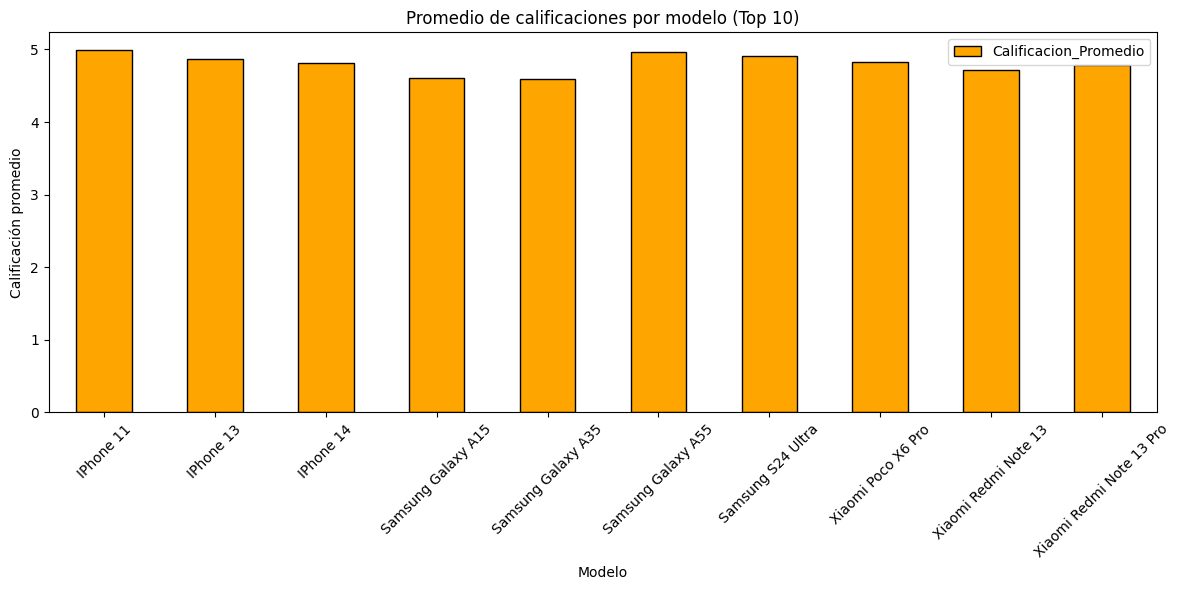

In [11]:
# Filtrar los 10 modelos más comentados
top_modelos = df['Modelo estandar'].value_counts().head(10).index

# Calcular la distribución por modelo
distribucion_modelo = df[df['Modelo estandar'].isin(top_modelos)].groupby('Modelo estandar').agg(
    Total_Comentarios=('calificacion', 'count'),
    Calificacion_Promedio=('calificacion', 'mean')
)

# Proporción de calificaciones por modelo
proporcion_calificaciones_modelo = df[df['Modelo estandar'].isin(top_modelos)].groupby(['Modelo estandar', 'calificacion']).size().unstack(fill_value=0)
proporcion_calificaciones_modelo = proporcion_calificaciones_modelo.div(proporcion_calificaciones_modelo.sum(axis=1), axis=0) * 100

# Unir ambas tablas
analisis_modelo = distribucion_modelo.join(proporcion_calificaciones_modelo)

# Mostrar resultados
print("Análisis por modelo:")
print(analisis_modelo)

# Visualización
analisis_modelo[['Calificacion_Promedio']].plot(kind='bar', figsize=(12, 6), color='orange', edgecolor='black')
plt.title("Promedio de calificaciones por modelo (Top 10)")
plt.xlabel("Modelo")
plt.ylabel("Calificación promedio")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


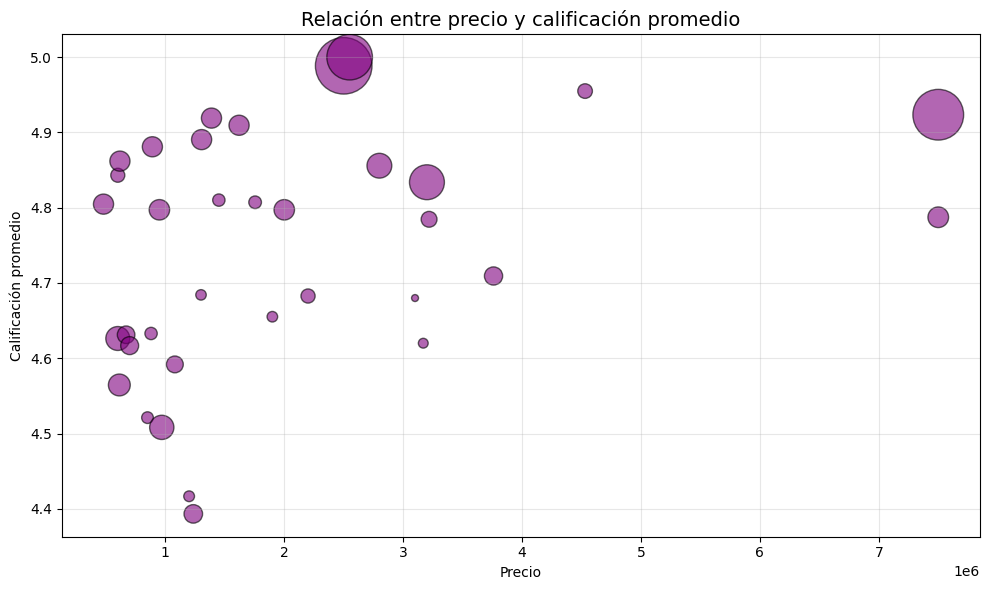

In [13]:
# Relación entre precio y calificación promedio
relacion_precio_calificacion = df.groupby('Precio').agg(
    Calificacion_Promedio=('calificacion', 'mean'),
    Total_Comentarios=('calificacion', 'count')
).reset_index()

# Visualización: Precio vs Calificación promedio
plt.figure(figsize=(10, 6))
plt.scatter(relacion_precio_calificacion['Precio'], relacion_precio_calificacion['Calificacion_Promedio'],
            s=relacion_precio_calificacion['Total_Comentarios'], alpha=0.6, color='purple', edgecolor='black')
plt.title("Relación entre precio y calificación promedio", fontsize=14)
plt.xlabel("Precio")
plt.ylabel("Calificación promedio")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [20]:
from transformers import pipeline

# Configurar el modelo preentrenado de Hugging Face para análisis de sentimientos
analizador_sentimientos = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Función para clasificar un comentario con BERT
def clasificar_sentimiento_bert(comentario):
    try:
        resultado = analizador_sentimientos(comentario)
        # Extraer la etiqueta de calificación (e.g., '5 stars' → 5)
        return int(resultado[0]['label'][0])
    except Exception as e:
        print(f"Error procesando el comentario: {comentario}. Error: {e}")
        return None

# Aplicar el modelo a la columna de comentarios limpios
df['Calificacion Predicha'] = df['comentario_limpio_sin_lematizar'].apply(clasificar_sentimiento_bert)

# Clasificar en polaridad (opcional)
def polaridad_desde_calificacion(calificacion):
    if calificacion >= 4:
        return "Positivo"
    elif calificacion == 3:
        return "Neutro"
    elif calificacion > 0:  # Filtrar posibles None
        return "Negativo"
    else:
        return None

# Crear la columna de polaridad
df['Sentimiento'] = df['Calificacion Predicha'].apply(polaridad_desde_calificacion)

# Verificar resultados
print(df[['comentario_limpio_sin_lematizar', 'Calificacion Predicha', 'Sentimiento']].head())


Device set to use cpu


                     comentario_limpio_sin_lematizar  Calificacion Predicha  \
0  Si corresponde a la foto tiene un excelente re...                      5   
1  El tamaño es el apropiado y para cargar facilm...                      4   
2  Muy buen producto a un excelente precio llego ...                      5   
3             Me gusto mucho y fue rapido la llegada                      5   
4          Cumple lo que promete es un lindo celular                      4   

  Sentimiento  
0    Positivo  
1    Positivo  
2    Positivo  
3    Positivo  
4    Positivo  


In [21]:
#Guardar df en un archivo CSV
df.to_csv(r"d:\Proyecto Web Scrapping\Analisis de Sentimientos\sentiment_analysis.csv", index=False)